<a href="https://colab.research.google.com/github/BitKnitting/FitHome_DeepLearning_1/blob/master/notebooks/dl_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

See [this medium article](https://medium.com/@happyday.mjohnson/diy-sensors-and-deep-learning-applied-to-insights-into-electricity-use-part-1-fea2d33af3f9) for an introduction to this project.
# Deep Learning Steps - Data Loading and Preprocessing
This notebook is one in a series that tackles predicting whether a microwave is on or off based on aggregated electricity readings.

In this notebook we'll be focusing in on data loading and preprocessing.
# Our Input Data
We collected power readings using the parts discussed in the [medium article](https://medium.com/@happyday.mjohnson/diy-sensors-and-deep-learning-applied-to-insights-into-electricity-use-part-1-fea2d33af3f9).

# Training, validation, and Test Data Features
The Features we'll use in our deep learning model include:
- __Aggregate power readings__ come from [a FitHome monitor at the breaker box](https://github.com/BitKnitting/FitHome/wiki/ElectricityMonitor).  I have slightly modified the monitor's firmware for this project.
- __Aggregate reactive power readings__ As pointed out [in this article](https://www.elprocus.com/importance-of-reactive-power-in-power-system-network/), _Transformers, motors, generators and other electrical devices require reactive power to produce magnetic flux._ Devices like hair dryers, lamps, heaters - those things that use all the power don't need reactive power.  By including reactive power as a feature, devices can be included or eliminated based on the amount of reactive power they require.
- __Hour of the day__: Many appliances - like the microwave - are typically used at the same time each day.  By using this feature, I am expecting the modeling will be better.  
  
We will not send current and voltage readings because active power as a [feature extraction](https://en.wikipedia.org/wiki/Feature_extraction) of current and voltage because P = IV.

# Target Data
Besides the aggregate power, aggregate reactive power, and hour of the day, our dataframe will include a column of 0's and 1's.  If there is a 1 in the row, the microwave was on when the aggregate power reading was recordered.  A 0 will be in the row if the microwave was off.

A 1 is in the column if the microwave's power reading is at least one standard deviation.

# Loading the data

[We have captured previous aggregate and microwave readings in our GitHub](https://github.com/BitKnitting/FitHome_mongodb/tree/master/data_results).  If you want to "play" with these, skip the mongodb steps.
- 
The first step is to get the aggregate and microwave readings out of mongodb and into two pickled Pandas dataframes that are then compressed into Zip file.  
## Steps
- Open a remote ssh session on the Rasp Pi.  Go into the directory where the [mongodb project](https://github.com/BitKnitting/FitHome_mongodb) is located and activate the virtual environment, e.g.:  

```
pi@raspberrypi:~/projects/FitHome_mongodb $ source venv/bin/activate
(mongodb) pi@raspberrypi:~/projects/FitHome_mongodb $
```
- Go into the data_results directory, e.g.:  
  
```
(mongodb) pi@raspberrypi:~/projects/FitHome_mongodb $ cd data_results
(mongodb) pi@raspberrypi:~/projects/FitHome_mongodb/data_results $ ls -la
total 4836
drwxr-xr-x 2 pi pi    4096 Dec 26 22:59 .
drwxrwxrwx 7 pi pi    4096 Dec 22 20:47 ..
-rw-r--r-- 1 pi pi 2338283 Dec 26 22:59 aggregate.pkl.zip
-rw-r--r-- 1 pi pi     495 Dec  1 16:23 json_to_pickle.py
-rw-r--r-- 1 pi pi 2590499 Dec 26 22:59 microwave.pkl.zip
-rw-r--r-- 1 pi pi    4096 Nov 28 14:30 ._mongo_to_pandas
-rwxr--r-- 1 pi pi    1377 Dec  1 16:24 mongo_to_pandas
```
- Run the script twice, once to get microwave data and another to get the aggregate data. The two mongodb collections are aggregate and microwave.  The collections are in the FitHome database.  e.g.:   
  
```
(mongodb) pi@raspberrypi:~/projects/FitHome_mongodb/data_results $ . mongo_to_pandas
****************************
Please start within the venv
****************************
Enter the db name: FitHome
Enter the collection name: microwave
The db name is FitHome
The collection name is microwave
Continue (y or n)? y
Getting readings out of mongodb into a json file...
connected to: 127.0.0.1
exported 427494 records
Pickling the json file ...
Zipping the pickled file...
updating: microwave.pkl (deflated 70%)
Deleting unused files...
Created file microwave.pkl.zip.
```  
- Use Git to push changes to your GitHub repository.
- Load the Data into our colab notebook.  We use a url to the "raw" data in the GitHub repo.
- [aggregate data](



In [24]:
# @title imports
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
!wget https://raw.githubusercontent.com/BitKnitting/transfer_nilm_exploration/master/code/python_lib/ziptodf.py
import ziptodf
!wget https://raw.githubusercontent.com/BitKnitting/transfer_nilm_exploration/master/code/python_lib/plots.py
import plots

--2020-01-05 13:11:24--  https://raw.githubusercontent.com/BitKnitting/transfer_nilm_exploration/master/code/python_lib/ziptodf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1361 (1.3K) [text/plain]
Saving to: ‘ziptodf.py.1’

ziptodf.py.1        100%[===================>]   1.33K  --.-KB/s    in 0s      

2020-01-05 13:11:24 (399 MB/s) - ‘ziptodf.py.1’ saved [1361/1361]

--2020-01-05 13:11:26--  https://raw.githubusercontent.com/BitKnitting/transfer_nilm_exploration/master/code/python_lib/plots.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 O

# Load the Data and Start Pre-processing

We wrote a python script - [ziptodf.get_data_frame_from_pkl_zip](https://github.com/BitKnitting/transfer_nilm_exploration/blob/master/code/python_lib/ziptodf.py) - to simplify loading the data.  After loading, we:
- merge the microwave and aggregate collections into one dataframe based on rows with the same timestamp.
- remove any rows that contain NaN in any of the columns.
- set the dataframe's index to the timestamp.
- add an hours column.

In [0]:
def load_and_prepare_data():
  # Get the aggregate data and the microwave data
  aggregate = ziptodf.get_dataframe_from_pkl_zip('https://raw.githubusercontent.com/BitKnitting/FitHome_mongodb/master/data_results/aggregate.pkl.zip')
  microwave = ziptodf.get_dataframe_from_pkl_zip('https://raw.githubusercontent.com/BitKnitting/FitHome_mongodb/master/data_results/microwave.pkl.zip')
  # Merge based on sample timestamp
  df_merge = pd.merge_asof(aggregate,microwave,on='timestamp',tolerance=pd.Timedelta(seconds=1))
  # Drop Rows where there is NaN
  df_data = df_merge.dropna()
  # Set index to timestamp
  df_data = df_data.set_index('timestamp')
  # Create an Hour column
  hours = df_data.index.hour
  df_hours = pd.DataFrame(hours,index=df_data.index)
  df_hours = df_hours.rename({'timestamp': 'Hours'}, axis='columns')
  # Add the hours column to the dataframe.
  df_data = pd.concat((df_data,df_hours),axis=1)
  return df_data


In [0]:
df_input_data = load_and_prepare_data()

# Interesting stats
[ziptodf.get_data_frame_from_pkl_zip](https://github.com/BitKnitting/transfer_nilm_exploration/blob/master/code/python_lib/ziptodf.py) contains a function that sequences together several useful pandas commands for getting a feel for the size, shape, and general statistics of a dataframe.

In [27]:
ziptodf.print_stats(df_input_data,"Input Data")

Input Data
**************************
Start index: 2019-12-22 12:56:10.047039032-08:00
--------------------------
End index: 2019-12-27 09:36:44.551029921-08:00
--------------------------
Rank: 2
--------------------------
Shape: (188885, 5)
--------------------------
Data types: 
Pa       float64
Pr       float64
P        float64
I        float64
Hours      int64
dtype: object
--------------------------
Number of missing values:
Pa       0
Pr       0
P        0
I        0
Hours    0
dtype: int64
--------------------------
Summary Stats:
                   Pa             Pr  ...              I          Hours
count  188885.000000  188885.000000  ...  188885.000000  188885.000000
mean      319.377781     112.711950  ...       0.375820      11.469196
std       371.797652     197.681895  ...       0.937238       7.037241
min         0.000960       0.002880  ...       0.300981       0.000000
25%       106.655400      38.875840  ...       0.315763       5.000000
50%       196.916500      61.

# Explore Reading Gaps
There will be (many) times when the Rasp Pi won't get a reading from a monitor.  There could be something wrong with the wifi.  I've had interference from the microwave prevent the Smart Plug from being able to read and send data.  Let's explore the sampling rate in this section.
- what is the most common sampling rate?
- what gaps are there between readings?
- what is going on when the largest gaps occur?

## The Distribution of sampling rates.
Looking at a box plot and binning the sampling rate values is easiest to quickly get a feel for the distribution of sampling rates.

In [0]:
# @title Show Distribution of Sampling Rates
# Given the readings, returns a series of seconds between each reading.
# while the content is a timestamp, the datatype is an object.
def get_sample_rates(df):
  time_between_samples = df.index.to_series().diff()
  delta_seconds = df.index.to_series().diff().dt.seconds
  # Box Plot 
  ax = delta_seconds.plot.box(figsize=(3,15))
  ax.minorticks_on()
  ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
  ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  # Bins
  df_bins = delta_seconds.value_counts(bins=10000)
  print('Number of Samples within each bin (unit is seconds)')
  display(df_bins.head(30))
  # The first row will be NaN since it's about the time between samples.
  return time_between_samples[1:]

Number of Samples within each bin (unit is seconds)


(1.887, 2.011]      182778
(3.994, 4.005]        5011
(2.997, 3.008]         579
(4.99, 5.002]          360
(5.998, 6.01]           45
(6.995, 7.006]          32
(10.994, 11.005]        11
(12.998, 13.01]          7
(8.989, 9.0]             6
(11.99, 12.002]          5
(9.997, 10.008]          4
(22.989, 23.0]           4
(7.992, 8.003]           4
(78.989, 79.0]           3
(18.99, 19.002]          3
(27.995, 28.006]         3
(45.994, 46.005]         2
(42.992, 43.003]         2
(38.994, 39.005]         2
(21.992, 22.003]         2
(13.995, 14.006]         2
(14.992, 15.003]         2
(25.99, 26.002]          1
(48.995, 49.006]         1
(98.992, 99.003]         1
(96.998, 97.01]          1
(95.99, 96.002]          1
(91.992, 92.003]         1
(56.992, 57.003]         1
(46.99, 47.002]          1
Name: timestamp, dtype: int64

count                    188884
mean     0 days 00:00:02.223769
std      0 days 00:00:00.900164
min      0 days 00:00:02.118360
25%      0 days 00:00:02.134812
50%      0 days 00:00:02.139250
75%      0 days 00:00:02.145009
max      0 days 00:01:54.933013
Name: timestamp, dtype: object

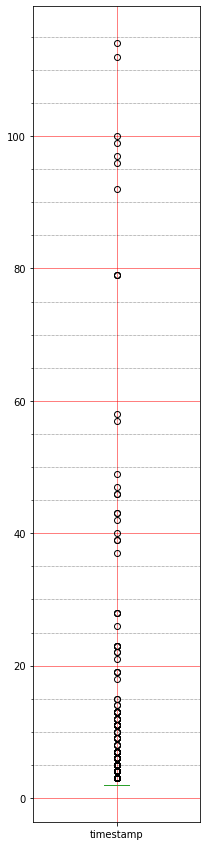

In [29]:
df_time_between_samples = get_sample_rates(df_input_data)
df_time_between_samples.describe()

# Exploring The Larger Sampling Gaps
While the majority of samples are 2 seconds apart, there are quite a few gaps!  Let's get a visualization of some of the larger gaps.

In [0]:

# @title Look more closely at samples where the sampling rate was much larger than the majority.
# df = dataframe of all samples.
# df_time_between_samples = the amount of seconds between readings.  This dataseries
# was created through a call to get_sample_rates()
# gap - the number of seconds until the time between samples is considered large.
def plot_gaps(df,df_time_between_samples,gap=10):
  fig = plt.figure(figsize=(30,16))
  
  # A row is True if it's timestamp is gap seconds more than the previous timestamp.
  filter = df_time_between_samples > pd.Timedelta(gap, unit='s')
  df_more_than_gap = df_time_between_samples.loc[filter]
  # Go through each reading that is at least gap seconds later than a previous reading
  print(f'\n***There are {len(df_more_than_gap)} gaps greater than {gap} seconds.***')
  # For each, make a plot based on the two gap points as well as a few earlier and later samples.
  ll = len(df_more_than_gap)
  cols = 3
  rows = ll // 3
  extra_row = ll % 3
  if (extra_row != 0):
    rows +=1
  for i in range(len(df_more_than_gap)):
    current_row = i // (rows-1) 
    current_col = i % (cols) 
    sample_time = df_more_than_gap.index[i]
    # print(sample_time)
    time_delta = df_more_than_gap[i]
    #  print(time_delta)
    m = 2
    #  Get up to 25 samples around
    while True:
      earlier = sample_time - m*time_delta
      later = sample_time + time_delta/4
      cnt = len(df[(df.index >= earlier) & (df.index <= later)])
      if (cnt <= 25):
        break
      m -= .2
    df_plot = df[(df.index >= earlier) & (df.index <= later)]  
    min_timestamp = df_plot.index.min()

    if (sample_time == min_timestamp):
      df_plot.index.shift(-10,freq='s')
    # print(f'minimum timestamp: {df_plot.index.min()}, maximum timestamp: {df_plot.index.max()}')
    ax = plt.subplot2grid((rows,cols),(current_row,current_col))
    # ax.plot(df_plot,style = '.-',ms=12)
    ax.plot(df_plot[['Pa','P']],'o-')
    ax.legend(['Pa','P'])
    
 
    ax.minorticks_on()
    ax.set_title(f'Gap size: {time_delta.seconds}s...Sample time: {sample_time}')
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  plt.tight_layout()  
  plt.show()
 



  


***There are 12 gaps greater than 50 seconds.***


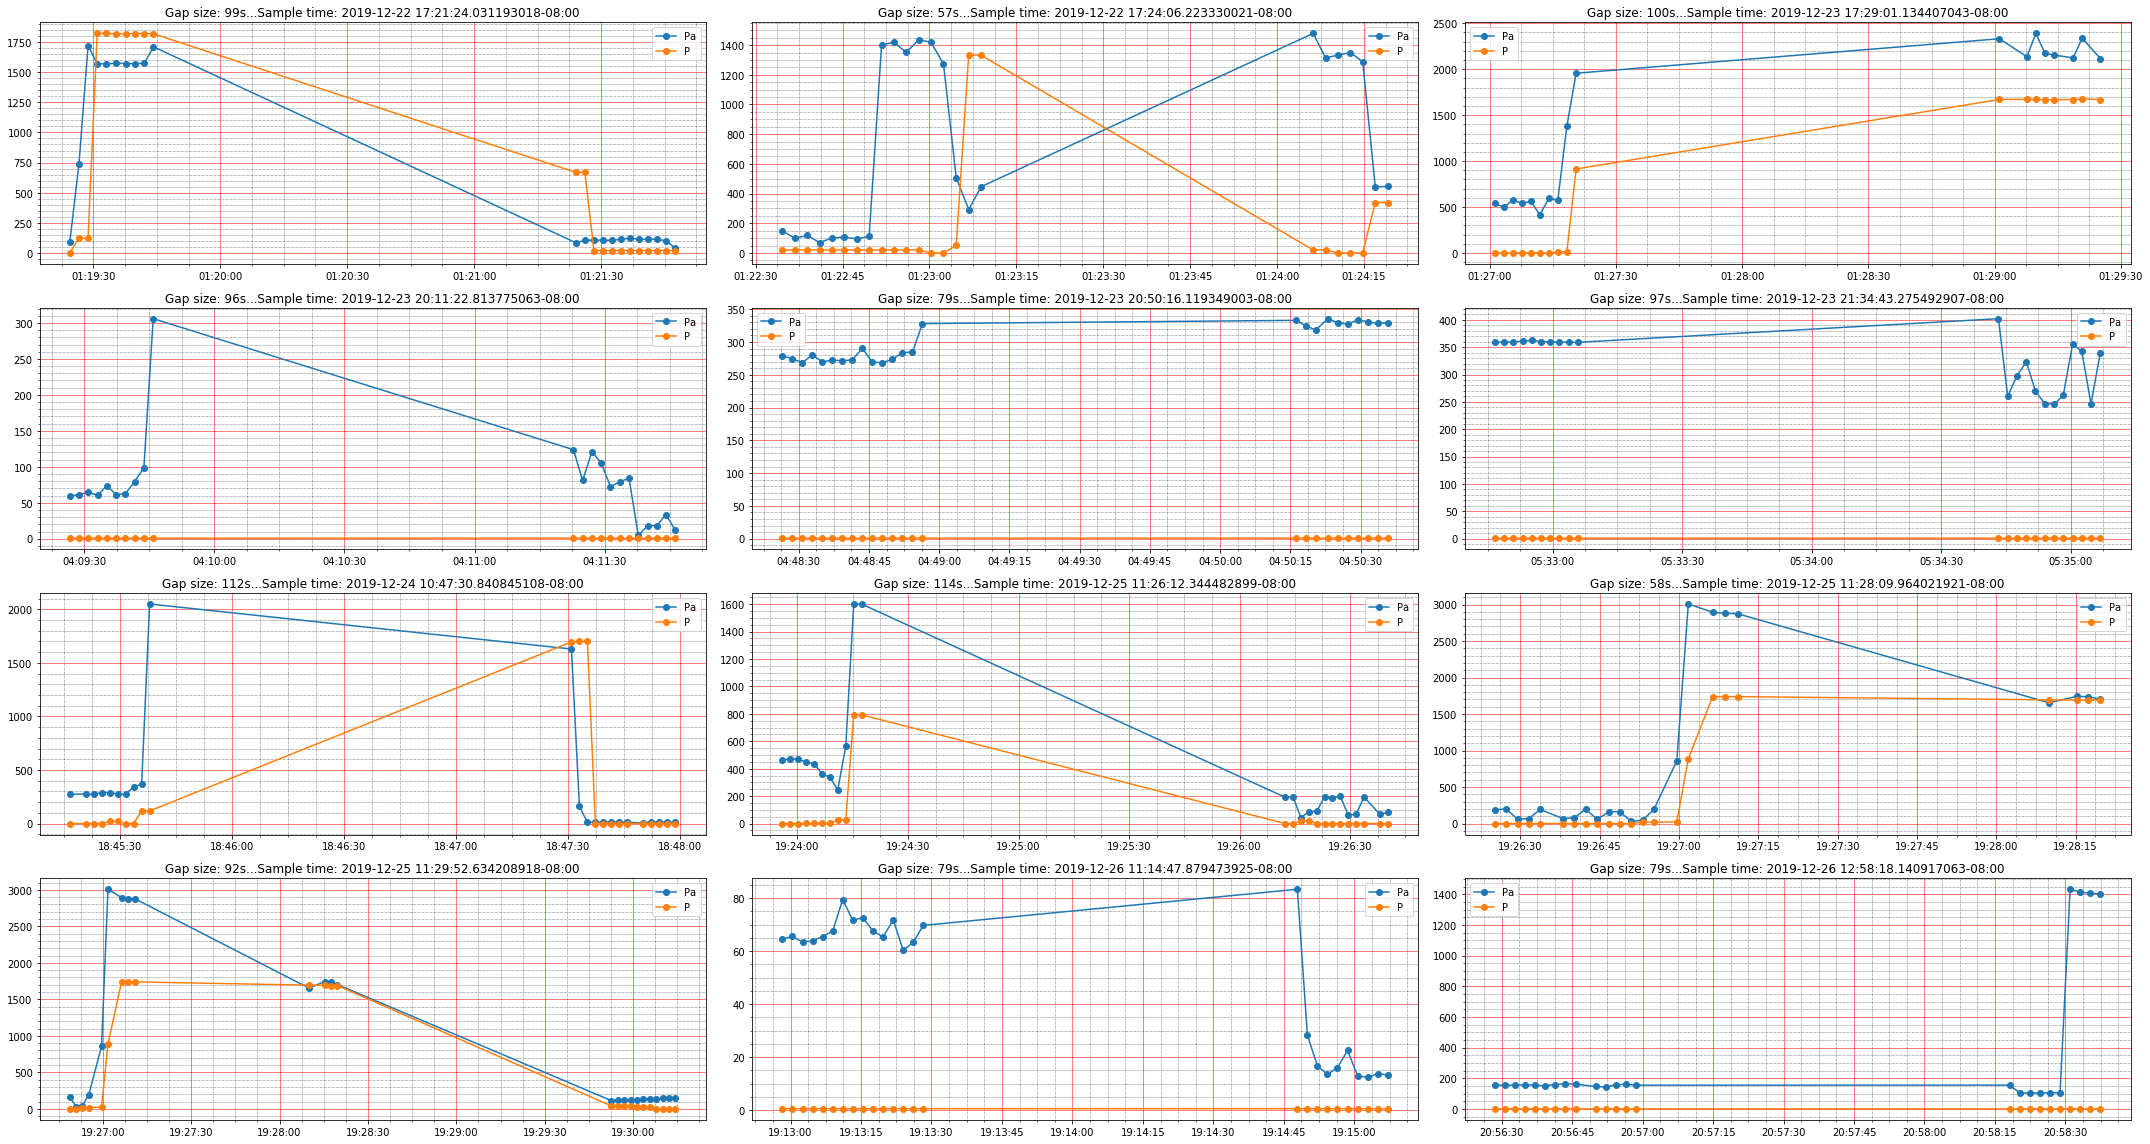

In [31]:
plot_gaps(df_input_data,df_time_between_samples,50)

# Thoughts on Gaps
Of course, there should be no gaps.  All readings should be 2 seconds apart.  But they are not.  I could resample.  But I am not sure how that would improve anything.  __For now, I'm not doing any resampling.  This is a judgement call I wish I could talk over with someone more experienced at this than I am.__

# Explore the Data
Let's get a feel for how the data works.  Of particular

<function matplotlib.pyplot.show>

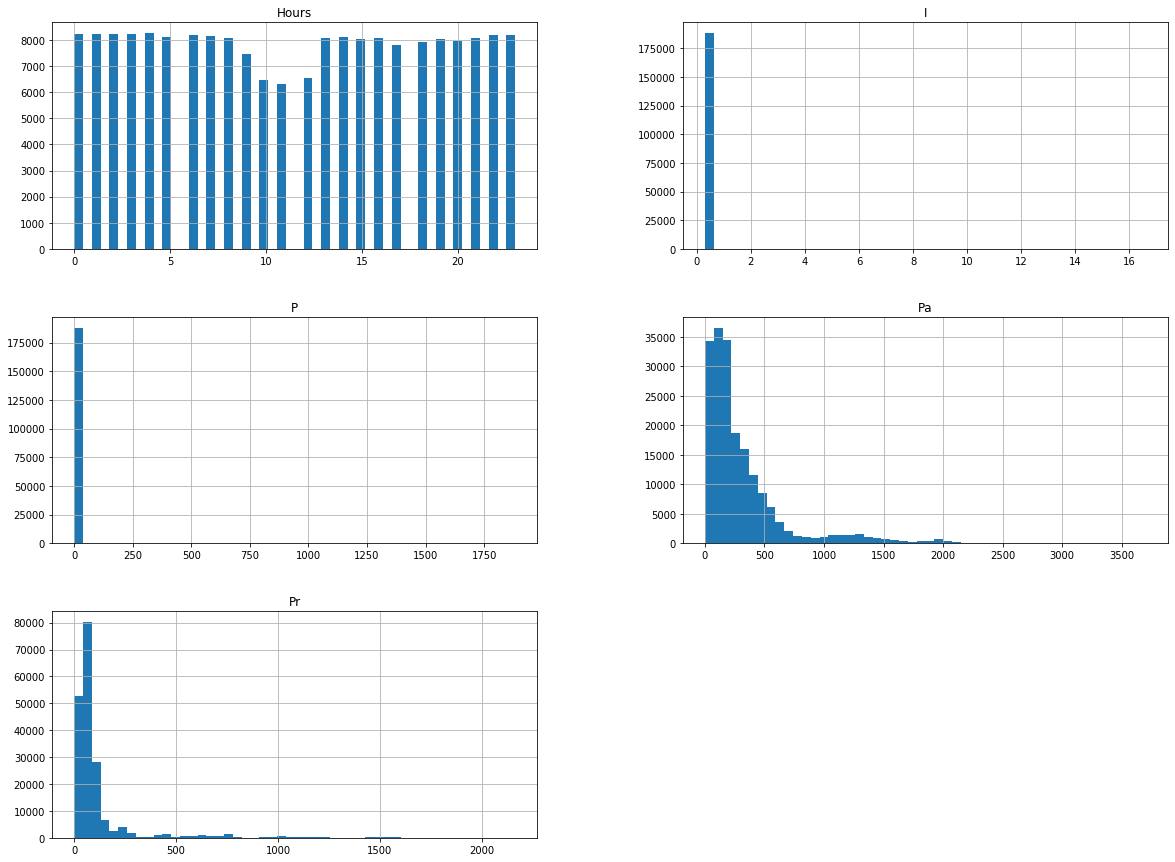

In [32]:
df_input_data.hist(bins=50,figsize=(20,15))
plt.show

# Plot the Readings

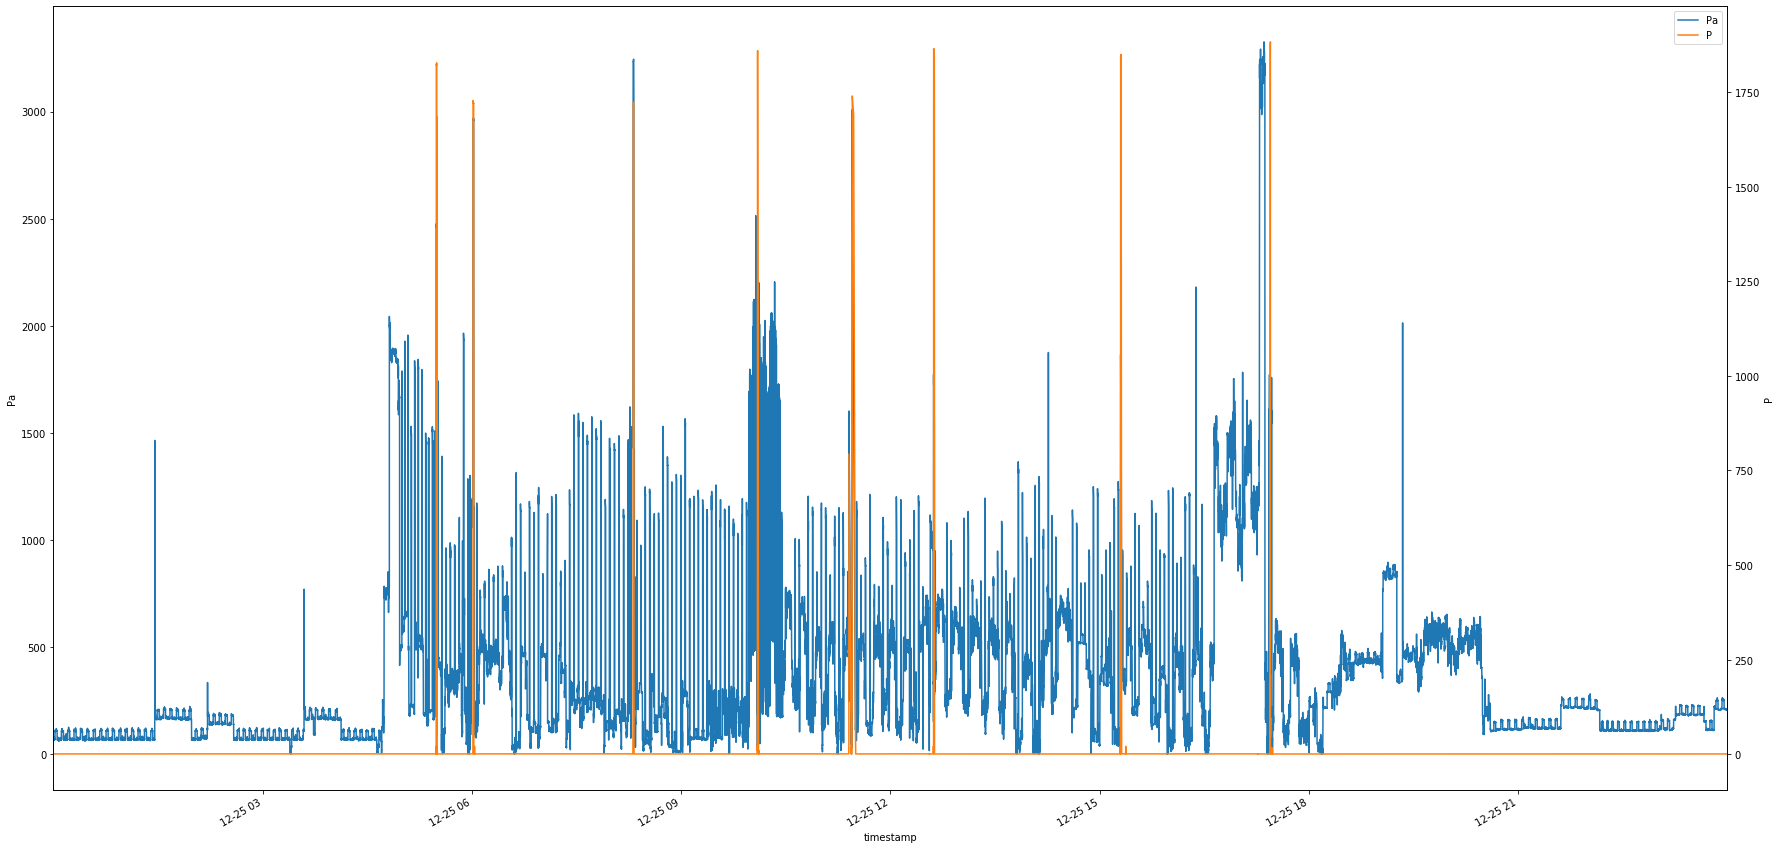

In [33]:
plots.multi_line(df_input_data['12-25-2019'][['Pa','P']],figsize=(30,16))

Let's zoom in...

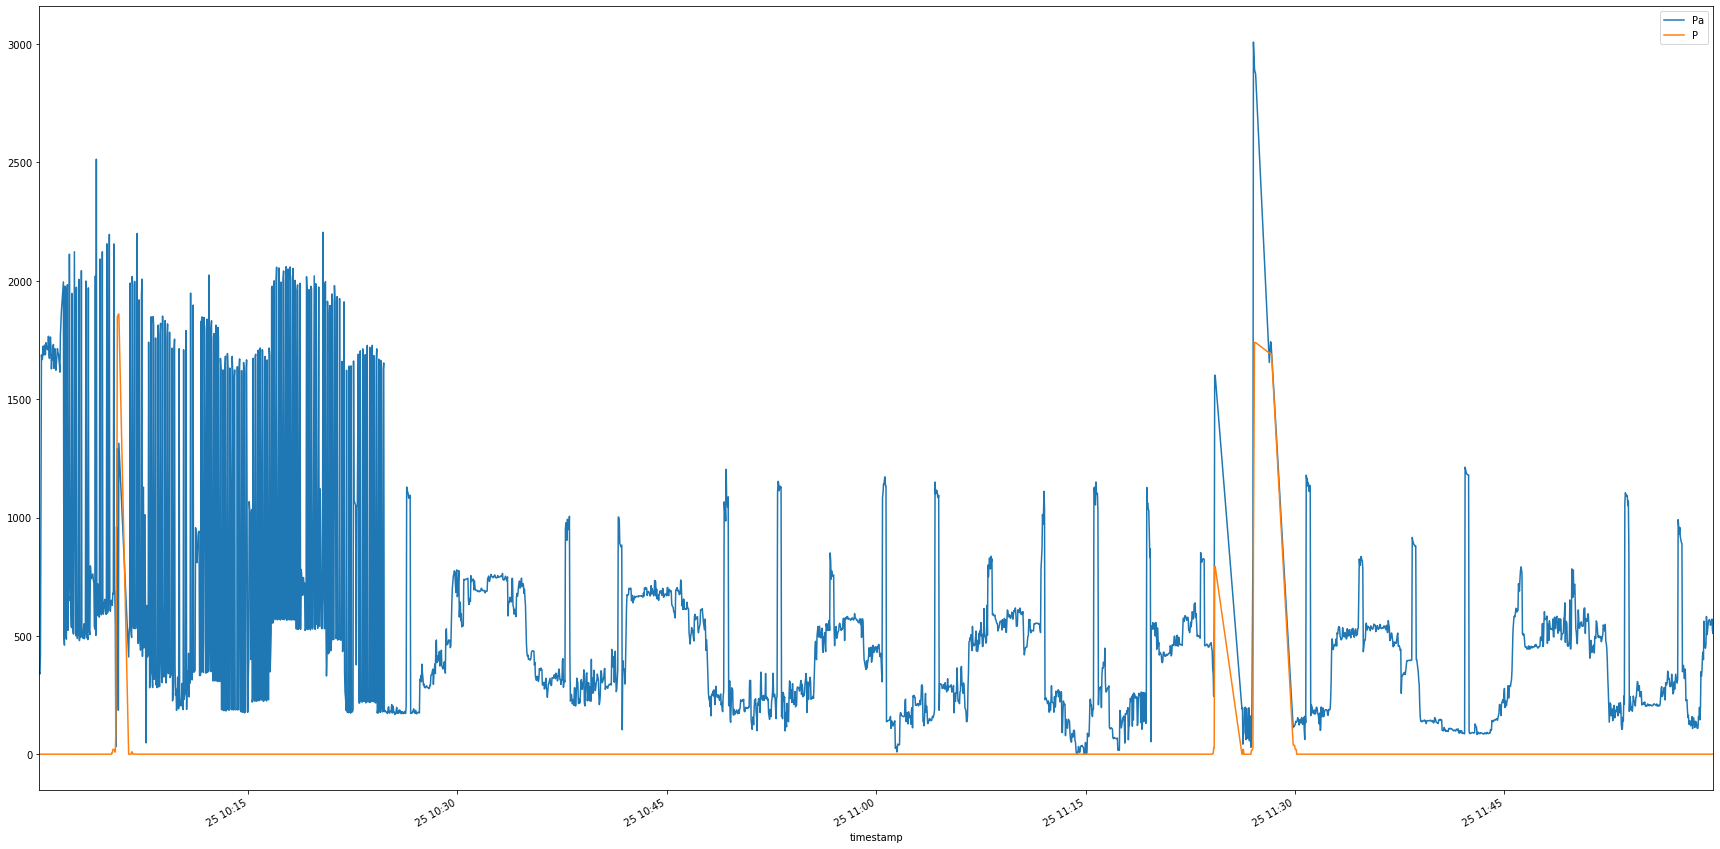

In [60]:
df_input_data['12-25-2019'][['Pa','P']].between_time('10:00','12:00').plot(figsize=(30,16))


# Change P and I columns to microwave on/off
When the value of 'P' is > than the standard deviation of all values of 'P', the microwave is on.  A new on/off column labeled microwave will be created.    If the readings, detect the microwave is on, the sample value in the microwave column will be 1.  Else, 0.

In [12]:
df_preprocessed_data = df_input_data
microwave_on = df_preprocessed_data['P'] > df_preprocessed_data['P'].std()
microwave_on = microwave_on.astype(int)

df_preprocessed_data['microwave'] = microwave_on
df_preprocessed_data.drop(labels=['P','I'],axis=1,inplace=True)
df_preprocessed_data.head()



,Pa,Pr,Hours,microwave
timestamp,,,,
2019-12-22 12:56:10.047039032-08:00,125.7882,83.34880,12,0
2019-12-22 12:56:12.195168972-08:00,1422.4850,99.86400,12,0
2019-12-22 12:56:14.329384089-08:00,1410.2520,99.29760,12,0
2019-12-22 12:56:16.460676908-08:00,1397.7160,98.30656,12,0
2019-12-22 12:56:18.594168901-08:00,1395.5460,98.63360,12,0


# Number of Microwave Readings
How many microwave readings are there in the data?

In [13]:
df_diff_microwave_readings = df_preprocessed_data['microwave'].diff()
df_microwave_reading_start = df_diff_microwave_readings[df_diff_microwave_readings > 0]
print(f'There are {len(df_microwave_reading_start)} microwave readings')

There are 44 microwave readings


# Closer Look when Microwave is on
Let's get an idea of what the readings look like within the time the microwave is on.

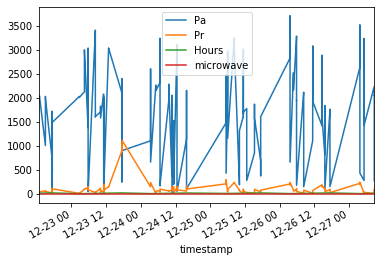

In [17]:
df_preprocessed_data[df_preprocessed_data['microwave']==1].plot()



# Feature Scaling
We'll be using standardization, i.e.: For each column that will be standardize, subtract the mean of the column (so the standard values always have a zero mean) and then divide by the standard deviation (so the resulting distribution has unit variance).  We chose standardization over min-max scaling because it is less affected by outliers.  

In [30]:
scaler = StandardScaler()
df_preprocessed_data[['Pa','Pr']] = scaler.fit_transform(df_preprocessed_data[['Pa','Pr']])
df_preprocessed_data.head()

,Pa,Pr,Hours,microwave
timestamp,,,,
2019-12-22 12:56:10.047039032-08:00,-0.520687,-0.148538,12,0
2019-12-22 12:56:12.195168972-08:00,2.966964,-0.064993,12,0
2019-12-22 12:56:14.329384089-08:00,2.934061,-0.067858,12,0
2019-12-22 12:56:16.460676908-08:00,2.900344,-0.072872,12,0
2019-12-22 12:56:18.594168901-08:00,2.894507,-0.071217,12,0


# Save the Dataframe
We're nearing the end of this notebook.  Let's save the data into our GitHub.  We'll load it in the next notebook of this series.

In the ideal, we'd be able to commit this file into the Deep Learning GitHub.  What we have done:
- Create the file in our Google drive at a location we can find easily.
- Copy the file into the local Git that syncs with the Deep Learning GitHub.

In [32]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
filename = '/content/drive/My Drive/FitHome/DeepLearning/dl_aggregate_microwave.pkl.zip'

df_preprocessed_data.to_pickle(filename,compression='zip')


The file is now located in my Google drive under FitHome/DeepLearning.  I copy the file to the [GitHub](https://github.com/BitKnitting/FitHome_DeepLearning_1/tree/master/data) location outside of colab.